In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# SW중심대학 공동 AI 경진대회

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

from xgboost import XGBRegressor

from sklearn import metrics

# 데이터 불러오기

In [2]:
pd.set_option('display.max_columns', 500) # 모든 컬럼 생략없이 출력
pd.set_option('display.max_row', 500) # row도 생략없이 다 출력

In [7]:
train = pd.read_csv("/home/nyh/Dacon_SW_competition/SW_competition/train.csv")
train = train.drop(['index', 'country'], axis=1) # index 컬럼 삭제 무의미한 데이터

test = pd.read_csv("/home/nyh/Dacon_SW_competition/SW_competition/test.csv")
test = test.drop(['index', 'country'], axis=1)

submission = pd.read_csv("/home/nyh/Dacon_SW_competition/SW_competition/sample_submission.csv")
submission.head()

,index,nerdiness
0,0,-1
1,1,-1
2,2,-1
3,3,-1
4,4,-1


## 라벨 인코딩

In [8]:
encoder = LabelEncoder()
train = train.astype('float64')
test = test.astype('float64')

## 이상치 처리

In [9]:
def outliers_iqr(data):
    q1, q3 = np.percentile(data, [25, 75])
    # 넘파이의 값을 퍼센트로 표시해주는 함수

    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    
    return np.where((data > upper_bound) | (data < lower_bound))

In [10]:
introelapse_index_data = outliers_iqr(train['introelapse'])[0]
testelapse_index_data = outliers_iqr(train['testelapse'])[0]
surveyelapse_index_data = outliers_iqr(train['surveyelapse'])[0]
age_index_data = outliers_iqr(train['age'])[0]
train.loc[train['familysize'] > 5, 'familysize'] = np.nan # 6명 이상의 가족 수 == 이상치 처리, 왠지모르겠는데 위의 함수로 처리가 안됨.
train['familysize'].value_counts()

train.loc[introelapse_index_data, 'introelapse'] = np.nan
train.loc[testelapse_index_data, 'testelapse'] = np.nan
train.loc[surveyelapse_index_data, 'surveyelapse'] = np.nan
train.loc[age_index_data, 'age'] = np.nan

introelapse_index_data = outliers_iqr(test['introelapse'])[0]
testelapse_index_data = outliers_iqr(test['testelapse'])[0]
surveyelapse_index_data = outliers_iqr(test['surveyelapse'])[0]
age_index_data = outliers_iqr(test['age'])[0]
test.loc[test['familysize'] > 5, 'familysize'] = np.nan # 6명 이상의 가족 수 == 이상치 처리, 왠지모르겠는데 위의 함수로 처리가 안됨.
test['familysize'].value_counts()

test.loc[introelapse_index_data, 'introelapse'] = np.nan
test.loc[testelapse_index_data, 'testelapse'] = np.nan
test.loc[surveyelapse_index_data, 'surveyelapse'] = np.nan
test.loc[age_index_data, 'age'] = np.nan

In [11]:
from sklearn.impute import SimpleImputer
fill=SimpleImputer(missing_values=np.nan , strategy='mean')
train = pd.DataFrame(fill.fit_transform(train), columns = train.columns)
test = pd.DataFrame(fill.fit_transform(test), columns = test.columns)

# Start EDA

In [12]:
list_Questions = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'nerdiness']

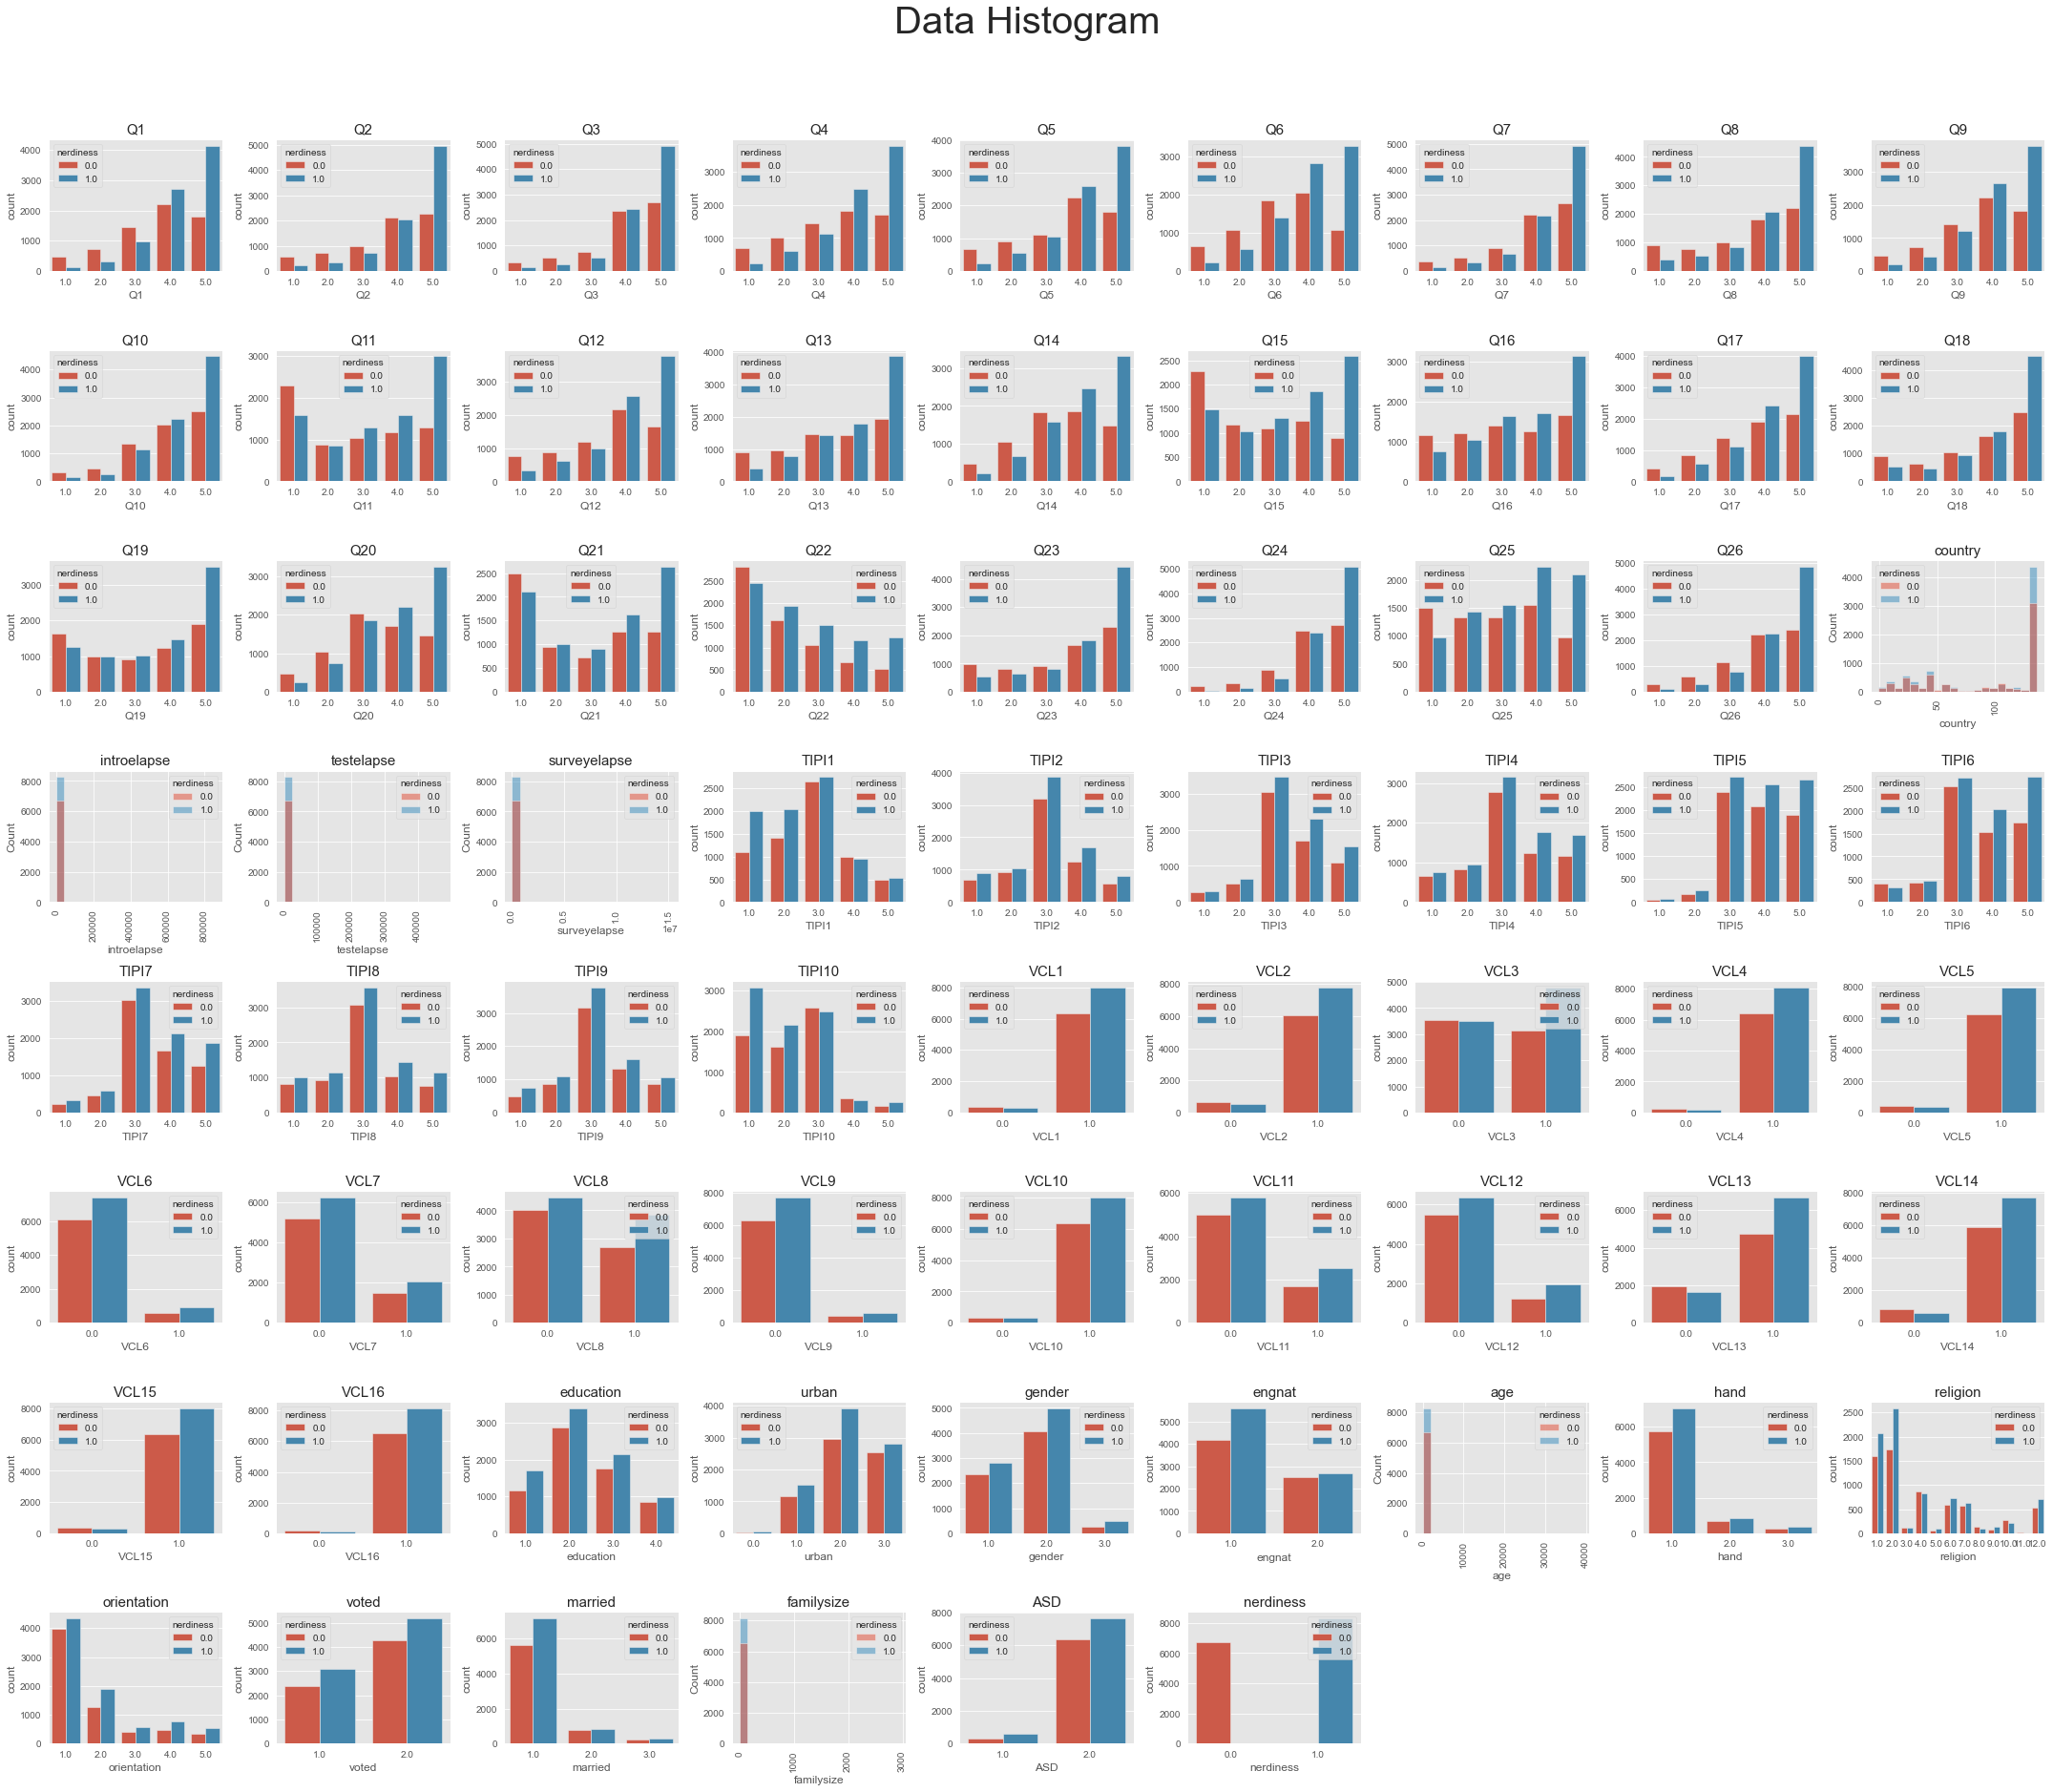

In [ ]:
plt.style.use('ggplot')

# 히스토그램을 사용해서 데이터의 분포 살펴보기
plt.figure(figsize=(30, 30))
plt.suptitle("Data Histogram", fontsize=40)

# id는 제외하고 시각화
cols = train.columns
for i in range(len(cols)):
    plt.subplot(9, 9, i + 1)  # 최대 5 by 5, 25개의 특징 분포를 확인할 수 있습니다.
    plt.title(cols[i], fontsize=15)  # 각 분포그림의 제목을 특징명으로 설정합니다.
    if len(train[cols[i]].unique()) < 20:  # 해당 특징의 고유한 값 종류가 20개가 넘으면
        sns.countplot(data=train, x=train[cols[i]], hue='nerdiness')  # 연령대별 target 분포
    else:
        plt.xticks(rotation=90)  # x축 text 회전
        sns.histplot(data=train, x=train[cols[i]], hue='nerdiness', bins=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

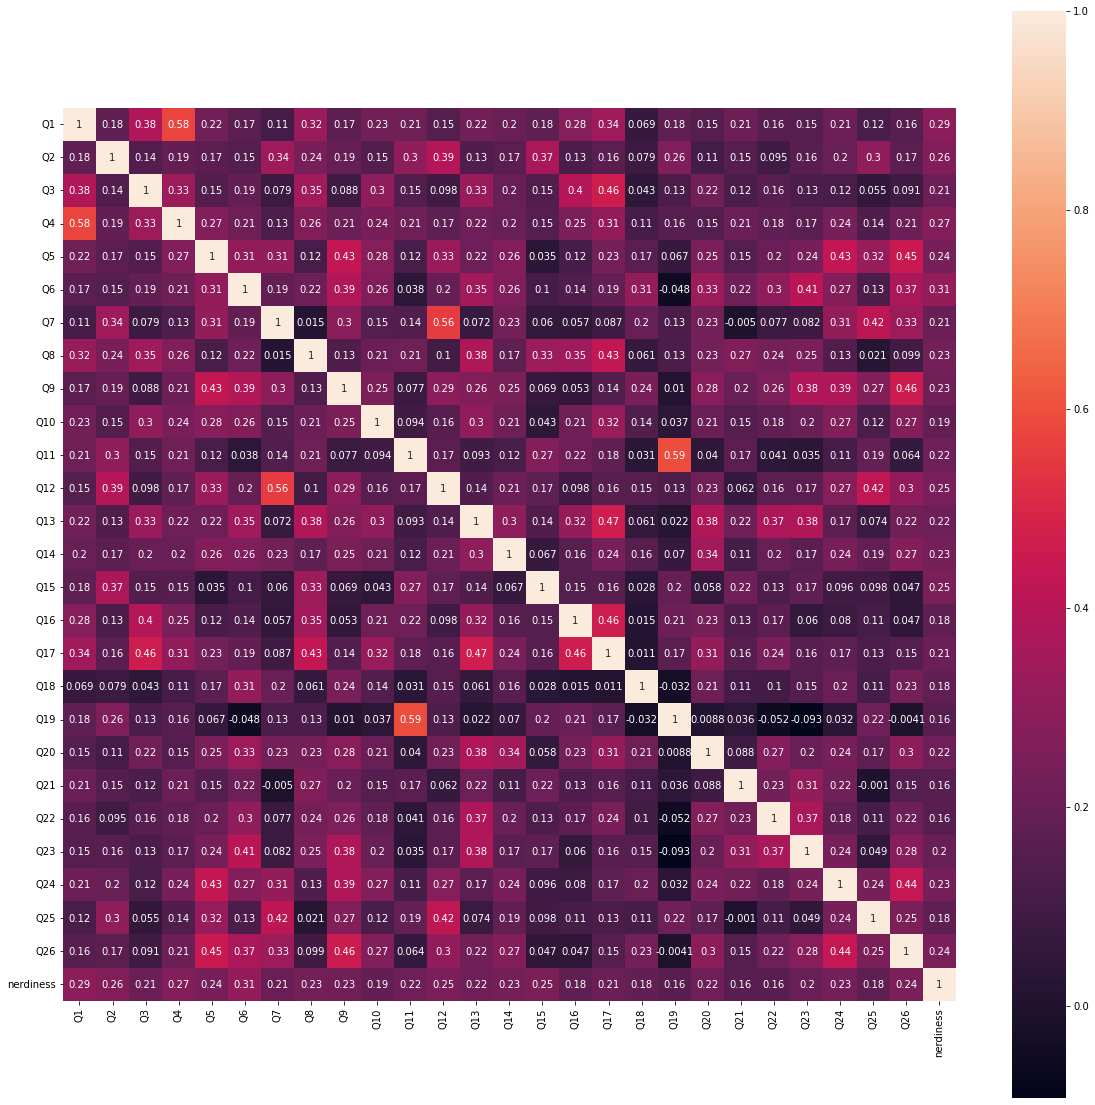

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplots(figsize=(20,20))
sns.heatmap(train[list_Questions].corr(), mask=np.zeros_like(train[list_Questions].corr(), dtype=bool),
            square=True, annot=True)
plt.show()

C:\Users\mhs\AppData\Local\Temp\ipykernel_210092\3915146891.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(train.corr(), dtype=np.bool)


<AxesSubplot:>

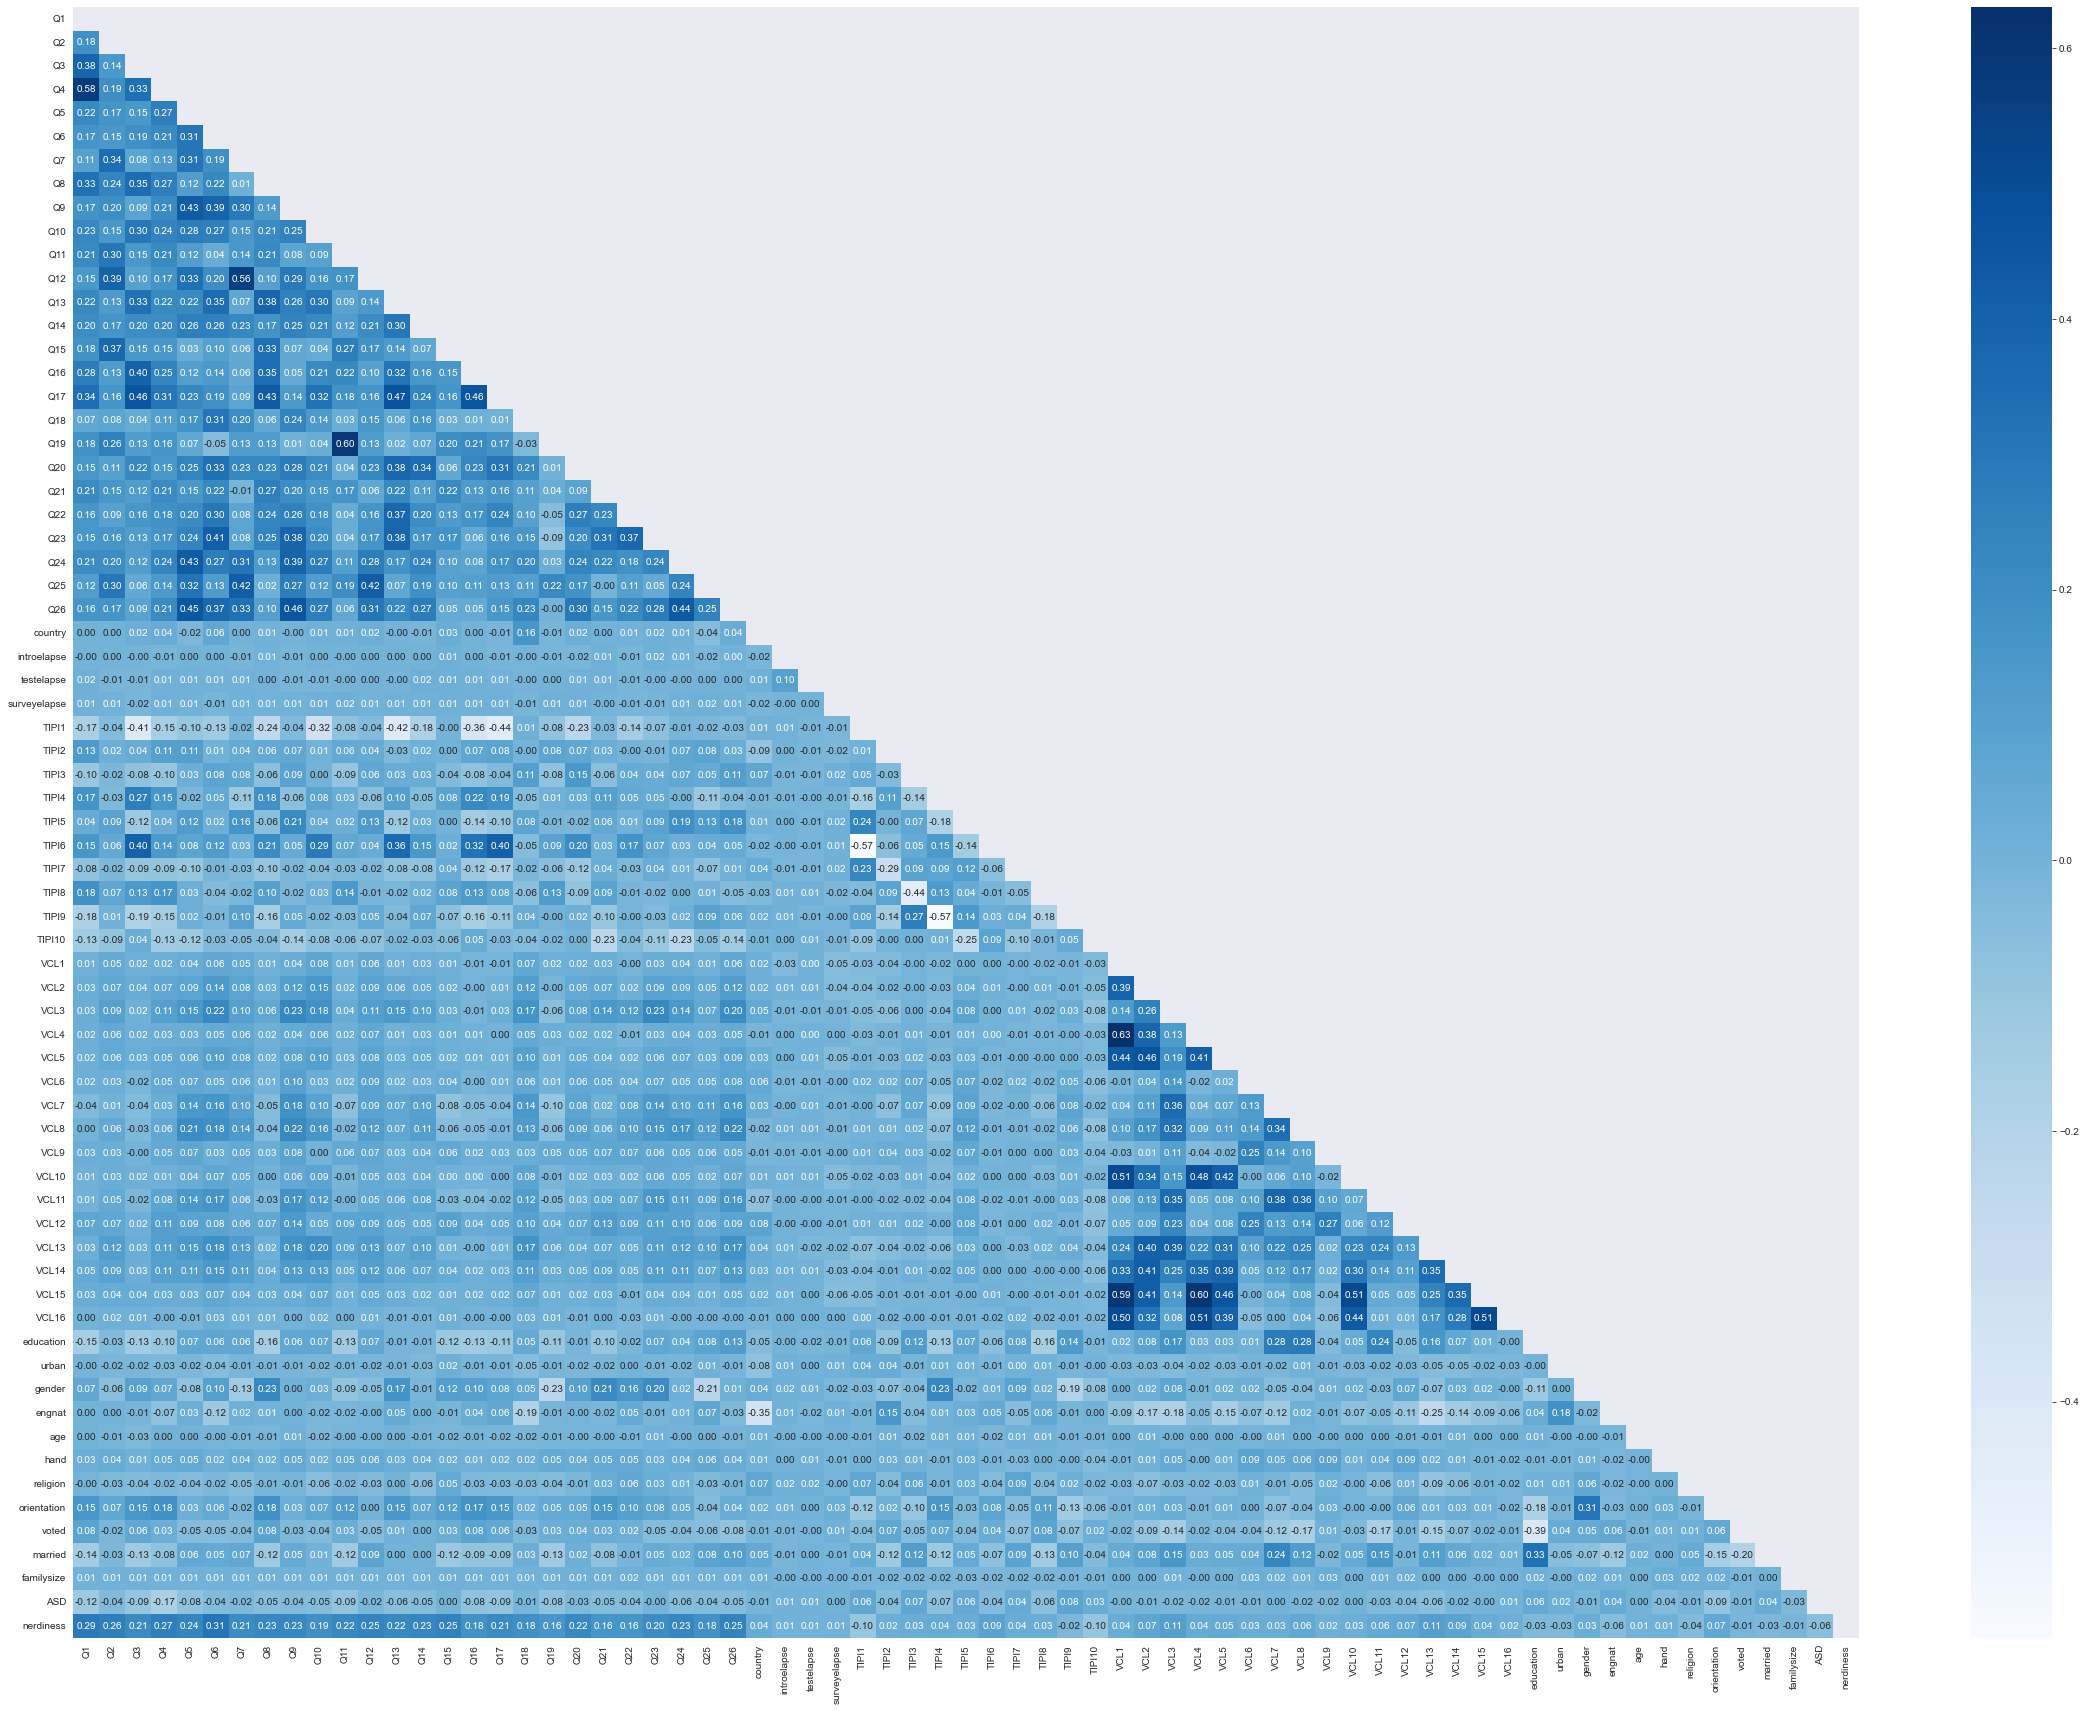

In [ ]:
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(40, 30))
sns.heatmap(train.corr(), annot=True, cmap='Blues', fmt='.2f', mask=mask)  #전체의 상관관계 시각화

<AxesSubplot:ylabel='nerdiness'>

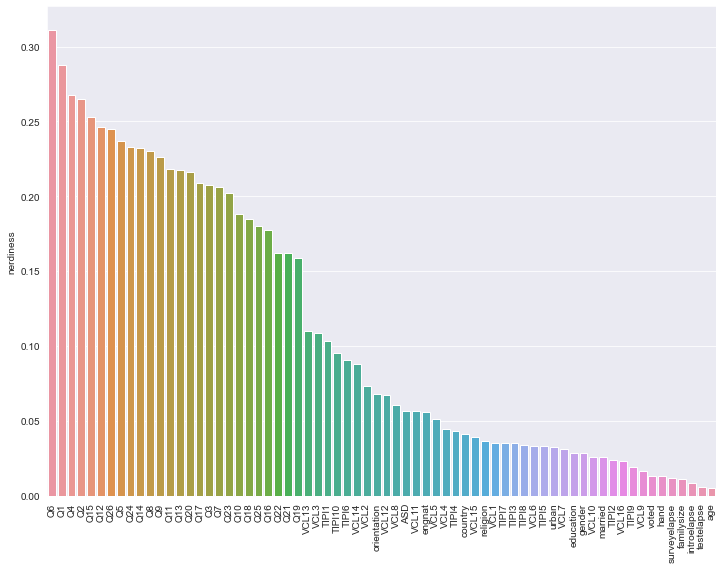

In [ ]:
plt.figure(figsize=(12, 9))
plt.xticks(rotation=90)
sns.barplot(x=abs(train.corr()['nerdiness']).sort_values(ascending=False)[1:].index,
            y=abs(train.corr()['nerdiness']).sort_values(ascending=False)[1:])